# Reuters Dataset


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# modify the default parameters of np.load to avoid error message "Object arrays cannot be loaded when allow_pickle=False"
if np.load.__name__ != '<lambda>': 
    np_load_old = np.load
    np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

import tensorflow as tf

reuters = tf.keras.datasets.reuters
models = tf.keras.models
layers = tf.keras.layers

In [2]:
NUM_WORDS = 10000
NUM_CLASSES = 46
(train_data, train_labels), (test_data, test_labels) = reuters.load_data( num_words = NUM_WORDS)

In [3]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value,key) for (key,value) in word_index.items()])

# helper function to decode index encoded newswires 
# index values 0, 1, 2 are reserved for "padding", "start of sequence", and "unknown"
def decode_newswire( newswire ) : 
    return ' '.join([reverse_word_index.get(i-3, '?') for i in newswire])

print(decode_newswire(train_data[0]))

? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


In [4]:
# binary encoding of newswires - 1 if word is present
def vectorize_sequences( sequences, dimension = NUM_WORDS ):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i,sequence] = 1
    return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [5]:
# one-hot encoding of labels
to_categorical = tf.keras.utils.to_categorical
one_hot_train_labels = to_categorical(train_labels, num_classes = NUM_CLASSES)
one_hot_test_labels = to_categorical(test_labels, num_classes = NUM_CLASSES)

In [6]:
# model definition
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape = (NUM_WORDS,)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(46, activation='softmax'))
    return model
    
model = build_model()

W0830 16:29:50.852391 140098693633856 deprecation.py:506] From /home/shirish/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [7]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
# set aside validation set
VALIDATION_SIZE = 1000
x_val = x_train[:VALIDATION_SIZE]
partial_x_train = x_train[VALIDATION_SIZE:]
y_val = one_hot_train_labels[:VALIDATION_SIZE]
partial_y_train = one_hot_train_labels[VALIDATION_SIZE:]

In [9]:
# train model
history = model.fit(partial_x_train, partial_y_train, epochs = 20, 
                    batch_size = 512, validation_data = (x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 1s 102us/sample - loss: 2.6407 - acc: 0.5204 - val_loss: 1.7912 - val_acc: 0.6590
Epoch 2/20
7982/7982 [==============================] - 1s 70us/sample - loss: 1.4412 - acc: 0.7095 - val_loss: 1.3315 - val_acc: 0.7210
Epoch 3/20
7982/7982 [==============================] - 1s 79us/sample - loss: 1.0506 - acc: 0.7834 - val_loss: 1.1389 - val_acc: 0.7620
Epoch 4/20
7982/7982 [==============================] - 1s 91us/sample - loss: 0.8147 - acc: 0.8380 - val_loss: 1.0421 - val_acc: 0.7900
Epoch 5/20
7982/7982 [==============================] - 1s 72us/sample - loss: 0.6447 - acc: 0.8713 - val_loss: 0.9471 - val_acc: 0.8070
Epoch 6/20
7982/7982 [==============================] - 1s 71us/sample - loss: 0.5129 - acc: 0.8980 - val_loss: 0.9051 - val_acc: 0.8200
Epoch 7/20
7982/7982 [==============================] - 1s 71us/sample - loss: 0.4132 - acc: 0.9149 - val_loss: 0.8902 - val_acc:

In [10]:
# extract logs of loss and accuracy
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1,len(loss_values)+1)

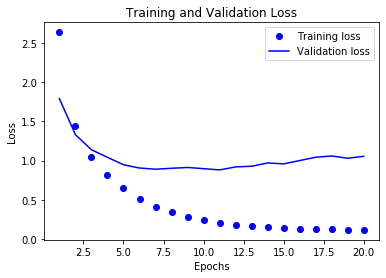

In [11]:
# plot loss for training and validation set
plt.clf()
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

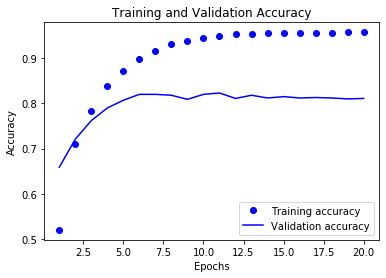

In [12]:
# plot accuracy for training and validation set
plt.clf()
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [14]:
# run on test set
results = model.evaluate(x_test, one_hot_test_labels)
print(results)

2246/2246 [==============================] - 0s 65us/sample - loss: 1.2237 - acc: 0.7867
[1.2236635147835246, 0.78673196]


## Error Analysis
We check in a couple of places where the prediction does not match the test label.  These two examples cast doubt on the labels used by the test set.  

In [22]:
predictions = model.predict(x_test)
decision = np.argmax(predictions, axis=1)

In [33]:
# note that the 4th test example (0-based index) was classified as 13 whereas the test_label is 4
print(decision[:34])
print(test_labels[:34])

[ 3 10  1  4 13  3  3  3  3  3  1  4  1  3  1 11  4  3 19  3  8  3  3  3
  9  3  4  6 10  3  3 10  4  3]
[ 3 10  1  4  4  3  3  3  3  3  5  4  1  3  1 11 23  3 19  3  8  3  3  3
  9  3  4  6 10  3  3 10 20  1]


In [32]:
# supposed topic names in reuters data
topic_indexes = {'copper': 6, 'livestock': 28, 'gold': 25, 'money-fx': 19, 'ipi': 30, 'trade': 11, 'cocoa': 0, 
 'iron-steel': 31, 'reserves': 12, 'tin': 26, 'zinc': 37, 'jobs': 34, 'ship': 13, 'cotton': 14, 
 'alum': 23, 'strategic-metal': 27, 'lead': 45, 'housing': 7, 'meal-feed': 22, 'gnp': 21, 'sugar': 10, 
 'rubber': 32, 'dlr': 40, 'veg-oil': 2, 'interest': 20, 'crude': 16, 'coffee': 9, 'wheat': 5, 
 'carcass': 15, 'lei': 35, 'gas': 41, 'nat-gas': 17, 'oilseed': 24, 'orange': 38, 'heat': 33, 
 'wpi': 43, 'silver': 42, 'cpi': 18, 'earn': 3, 'bop': 36, 'money-supply': 8, 'hog': 44, 'acq': 4, 
 'pet-chem': 39, 'grain': 1, 'retail': 29}

# it seems that the 4th test example is indeed about 'ship' (shipping?) and not about 'acq' (acquisitions?)
decode_newswire(test_data[4])

'? strong south ? winds were keeping many vessels trapped in the ice off the finnish and swedish coasts in one of the worst icy periods in the baltic for many years the finnish board of navigation said in finland and sweden up to 50 vessels were reported to be stuck in the ice and even the largest of the ? ? were having difficulties in breaking through to the ? ships ? officials said however icy conditions in the southern baltic at the soviet oil ports of ? and ? had eased they said weather officials in neighbouring sweden said the icy conditions in the baltic were the worst for 30 years with ships fighting a losing battle to keep moving in the coastal stretches of the gulf of ? which ? finland and sweden the ice is up to one ? thick with ? and ? packing it into almost ? walls three metres high swedish ? officials said weather forecasts say winds may ease during the weekend but a further drop in temperature could bring shipping to a standstill the officials said reuter 3'

In [34]:
# 10th example is classified 1 : 'grain' but the test label has it as 5 : 'wheat'
decode_newswire(test_data[10])

"? grain traders said they were still awaiting results of yesterday's u k intervention feed wheat tender for the home market the market sought to buy 340 000 tonnes more than double the remaining 150 000 tonnes available under the current tender however some of the tonnage included ? bids for supplies in the same stores since the tenders started last july ? 000 tonnes of british feed wheat have been sold back to the home market reuter 3"